In [10]:
# pytorch provides the torch.nn, torch.optim, Dataset and DataLoader
# to help you create and train neural networks.

# MNIST data setup
from pathlib import Path
import requests

In [13]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [14]:
import pickle
import gzip

In [15]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [18]:
from matplotlib import pyplot
import numpy as np

#pyplot.imshow(x_train[2], cmap='gray')
print(x_train[2].shape, type(x_train[2]))

(784,) <class 'numpy.ndarray'>


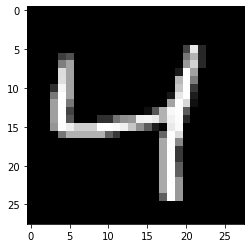

In [22]:
# since the data are store in flattened row of length 784
length = x_train[2].shape[0]
edge = int(np.sqrt(length))
demo_img = x_train[2].reshape((edge, edge))
pyplot.imshow(demo_img, cmap='gray')

In [23]:
# check the training dataset
x_train.shape

(50000, 784)

In [24]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [25]:
n, c

(50000, 784)

In [26]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [29]:
x_train[0, :].reshape((28, 28)).size()

torch.Size([28, 28])

In [30]:
# Neural net from scratch (no torch.nn)
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# requires_grad, do not want that step included in the gradient
# pytorch provides methods to create random or zero-filled tensors
# which we will use to create our weights and bias for a simple 
# linear model

# These are just regular tensors, with one very special addition:
# requires_grad_, this causes Pytorch to record all of the operations
# done onthe tensor. so that it can calculate the gradient during
# back-propagation automatically

weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [31]:
def log_softmax(x):
    """x.exp(), the input is not scalar but tensor """
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    """the @ stands for the dot product operation, call our
    function on one bath of data"""
    return log_softmax(xb @ weights + bias)

In [32]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5638, -1.6567, -2.5060, -1.9510, -2.5371, -2.5947, -2.8215, -2.0707,
        -2.6533, -2.3155], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [50]:
# negative log-likelihood to use as the loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_function = nll

In [51]:
yb = y_train[0:bs]
print(loss_function(preds, yb))

tensor(2.2709, grad_fn=<NegBackward>)


In [52]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [53]:
print(accuracy(preds, yb))

tensor(0.1719)


In [55]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 100  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_function(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [57]:
preds = model(x_valid)
print(accuracy(preds, y_valid))

tensor(0.9226)


In [58]:
import torch.nn.functional as F

# negative log likelihood loss and log softmax activation, Pytorch
# provides a single function F.cross_entropy combineds the two. 
loss_func = F.cross_entropy

from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3697, grad_fn=<NllLossBackward>)


In [59]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [60]:
print(loss_func(model(xb), yb))

tensor(0.0423, grad_fn=<NllLossBackward>)
